# This notebook is to explore if Ohmnet preserves the relationship of the nodes in the subnetwork like the original network

In [1]:
import sys
sys.path.append("../..")
import platform
import pandas as pd
import numpy as np
import os
import networkx as nx
from src.embedding.network_embedding import *
from src.eda.eda_functions import *
from src.eda.subset_network import *
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances as ed
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'
%load_ext autoreload
%autoreload 2

# Prepare data for Ohmnet

In [4]:
subnet1 = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\eda_derived\subnetworks_Jan_14\deg_mod=[4],non_deg_mod=[],num_genes=250,min_weight=0.008.csv', index_col = 0)

In [8]:
# convert df from adjacency to edgelist
subnet1.values[tuple([np.arange(len(subnet1))]*2)] = np.nan
subnet1_edge = subnet1.stack().reset_index()

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(subnet1.columns)
subnet1_edge.level_0 = le.transform(subnet1_edge.level_0) # convert gene id to number to work with Ohmnet
subnet1_edge.level_1 = le.transform(subnet1_edge.level_1)

LabelEncoder()

In [356]:
subnet1_edge = subnet1_edge[subnet1_edge['level_0'].isin([2627, 2999, 2319])] # take only 3 random source genes to pull out their neighbors
subnet1_edge = subnet1_edge[subnet1_edge[0] > 0.012] # and subset with weight > 0.012
subnet1_edge.to_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\subnet_test1.csv', index = 0)

In [2]:
subnet1_edge = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\subnet_test1.csv')

In [ ]:
# Then subnet1_edge is split into 2 dataframes with 12 genes + edges (source and target are the same) overlap 
# The 2 dataframes are then fed to Ohmnet to embed

In [320]:
# edge1 = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\test_edgelist1.txt', sep = '\t', header= None)
# edge2 = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\test_edgelist2.txt', sep = '\t', header= None)

In [324]:
## check how many nodes overlap betwen these two sub-subnetwork
# len(set(edge1[1]).intersection(edge2[1]))

258

# Embed the original network and see how strong the jaccard is 

In [2]:
subnet1_edge = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\subnet_test1.csv')
subnet1_edge.columns = ['source', 'target', 'weight']

In [5]:
subnet1_G = nx.convert_matrix.from_pandas_edgelist(subnet1_edge, source = 'source', target = 'target',
                                                   edge_attr = 'weight')

In [6]:
subnet1_emb = network_embedding(subnet1_G, 16, 10, 10, r'C:\Users\bbche\Documents\GitRepos\ohmnet\data', 'subnet1')

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.41s/it]


embedding data saved


In [3]:
subnet1_sub1 = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\test_edgelist1.txt', sep = '\t', header= None)
subnet1_sub2 = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\edgelists\test_edgelist2.txt', sep = '\t', header= None)
subnet1_sub1.columns = ['source', 'target', 'weight']
subnet1_sub2.columns = ['source', 'target', 'weight']

In [4]:
subnet1_sub1_G = nx.convert_matrix.from_pandas_edgelist(subnet1_sub1, source = 'source', target = 'target',
                                                        edge_attr = 'weight')
subnet1_sub2_G = nx.convert_matrix.from_pandas_edgelist(subnet1_sub2, source = 'source', target = 'target',
                                                        edge_attr = 'weight')

In [9]:
subnet1_sub1_emb = network_embedding(subnet1_sub1_G, 16, 10, 10, r'C:\Users\bbche\Documents\GitRepos\ohmnet\data', 'subnet1_sub1')
subnet1_sub2_emb = network_embedding(subnet1_sub2_G, 16, 10, 10, r'C:\Users\bbche\Documents\GitRepos\ohmnet\data', 'subnet1_sub2')

Computing transition probabilities:  18%|███████▋                                    | 74/421 [00:00<00:00, 732.74it/s]

embedding data saved


Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.35it/s]


embedding data saved


## Compare closest genes for each embedding to the original network by jaccard

In [4]:
def get_closest_genes_jaccard(network, emb, top_n, title):
    ed_data = ed(emb, emb)
    ed_df = pd.DataFrame(ed_data, index = emb.index, columns = emb.index)
    closest_genes1 = [] # find closest genes in the subnetwork
    closest_genes2 = [] # find closest genes in the embedding
    for gene in network.source.unique():
        closest_genes1.append(network[network.source == gene].sort_values('weight', ascending = False)['target'][:top_n])
        top_n_genes = ed_df[gene].sort_values()[1:top_n+1].index
        closest_genes2.append(top_n_genes)
    jac_list = []
    for i in range(len(closest_genes1)):
        jac_list.append(jaccard_similarity(closest_genes1[i], closest_genes2[i]))
#     xticks = le.inverse_transform(subnet1_edge.source.unique())
    plt.rcParams.update({'font.size':18})
    plt.bar(network.source.unique().astype(str), jac_list)
    plt.ylim(0, 1)
    plt.ylabel('Jaccard similarity')
    plt.xlabel('gene')
    plt.xticks(rotation = 45, ha = 'right')
    plt.title(title)
    plt.show()
    plt.close()

In [15]:
subnet1_emb = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\embedded_len16_walk10_subnet1.csv', index_col = 0)
subnet1_sub1_emb = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\embedded_len16_walk10_subnet1_sub1.csv', index_col = 0)
subnet1_sub2_emb = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\embedded_len16_walk10_subnet1_sub2.csv', index_col = 0)

In [6]:
# ohmnet output (embedding)
ohmnet_emb = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\tmp\internal_vectors.emb', sep = ' ', skiprows=1, header = None, index_col = 0)
ohmnet_index = list(ohmnet_emb.index)
new_index = list(map(lambda x:int(x.split('__')[1]), ohmnet_index))
ohmnet_emb.index = new_index

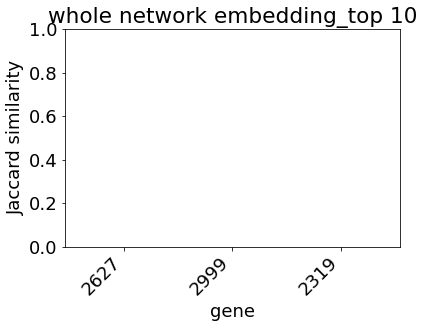

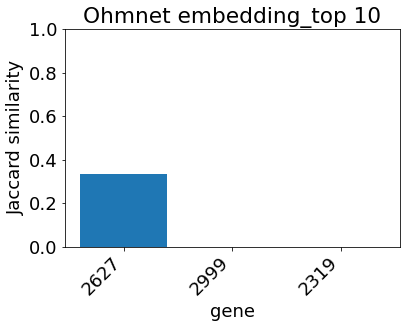

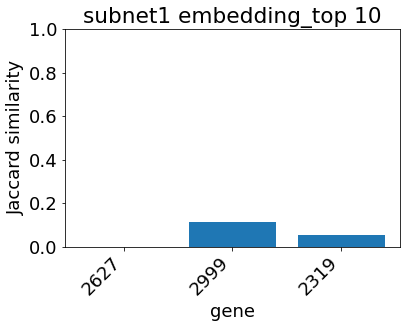

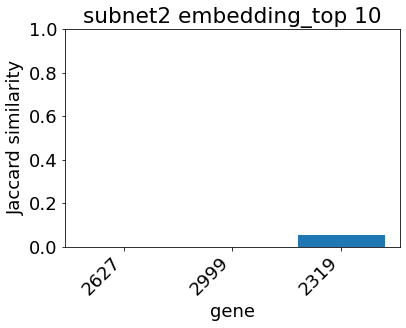

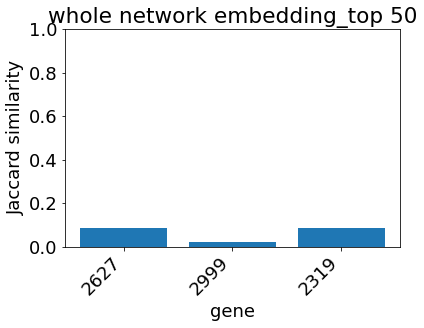

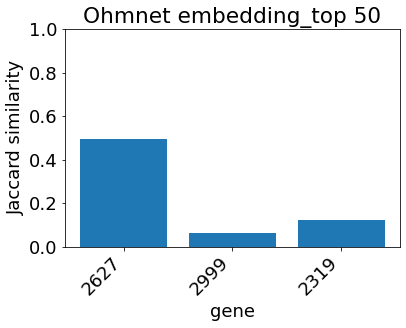

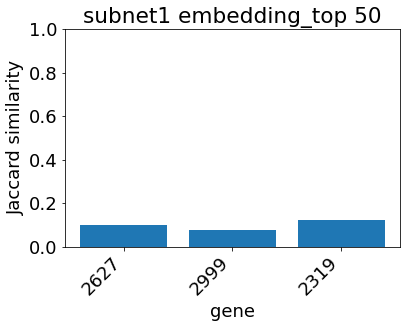

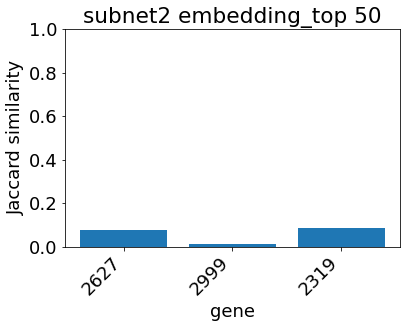

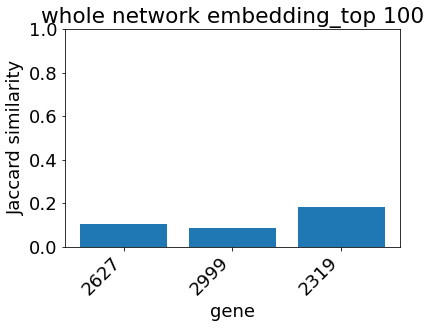

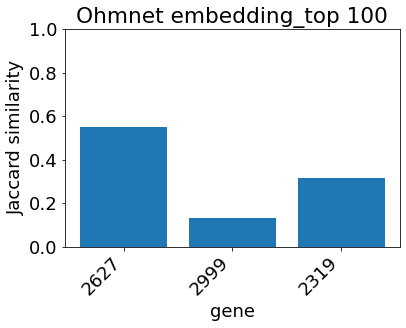

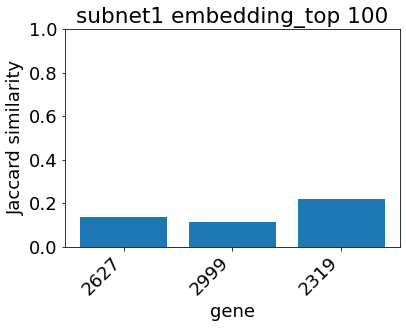

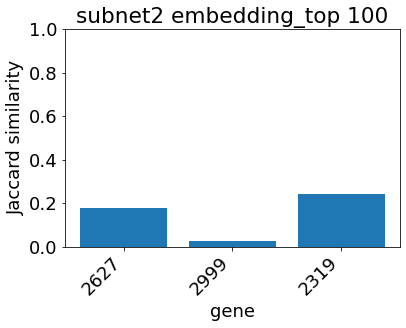

In [10]:
emb_list = [subnet1_emb, ohmnet_emb, subnet1_sub1_emb, subnet1_sub2_emb]
emb_names = ['whole network embedding', 'Ohmnet embedding', 'subnet1 embedding', 'subnet2 embedding']
for n in [10, 50, 100]:
    for i in range(len(emb_list)):
        get_closest_genes_jaccard(subnet1_edge, emb_list[i], n, f'{emb_names[i]}_top {n}')

## Compare between different walks

In [8]:
subnet1_emb_100 = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\embedded_len16_walk100_subnet1.csv', index_col = 0)
subnet1_sub1_emb_100 = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\embedded_len16_walk100_subnet1_sub1.csv', index_col = 0)
subnet1_sub2_emb_100 = pd.read_csv(r'C:\Users\bbche\Documents\GitRepos\ohmnet\data\embedded_len16_walk100_subnet1_sub2.csv', index_col = 0)

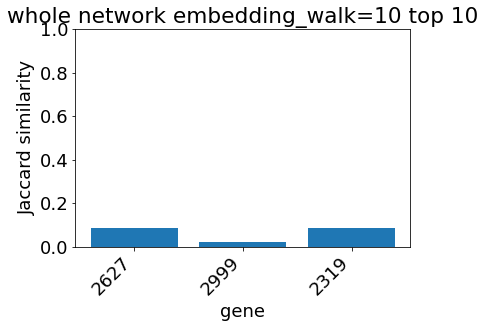

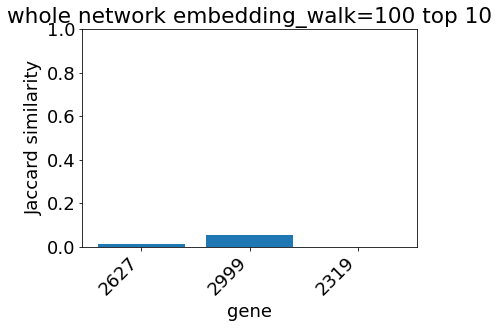

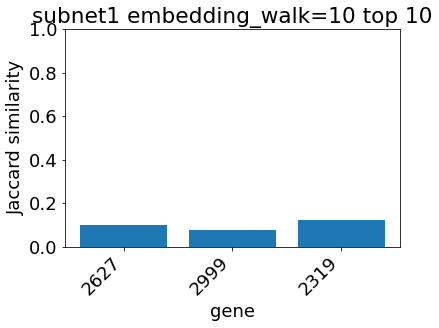

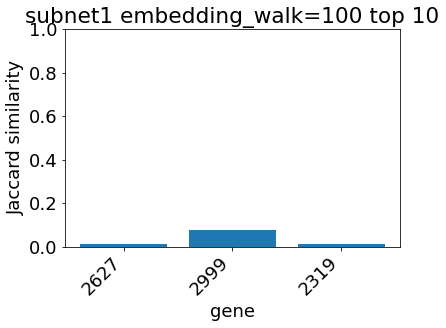

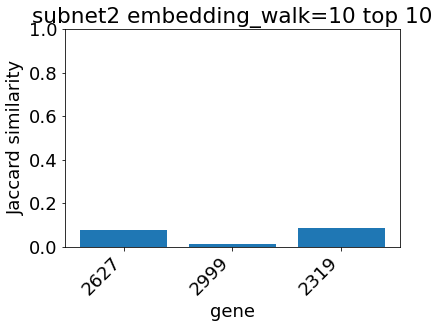

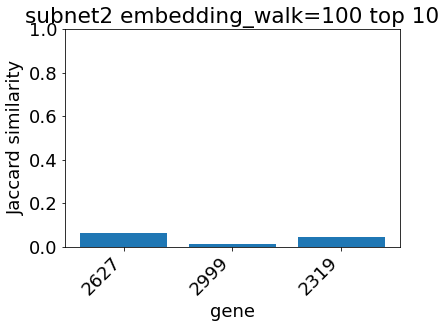

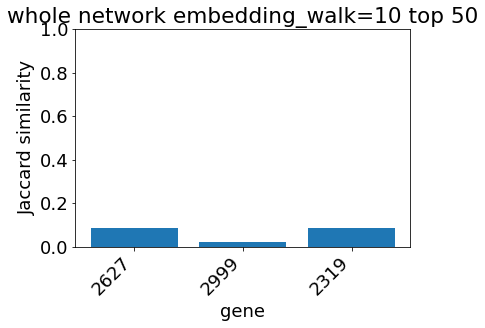

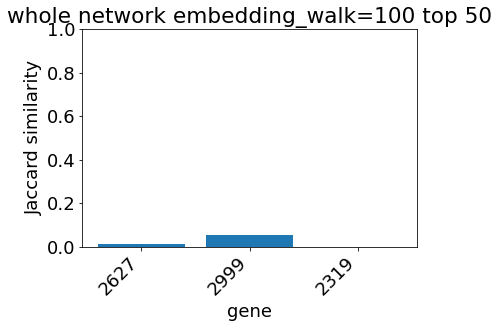

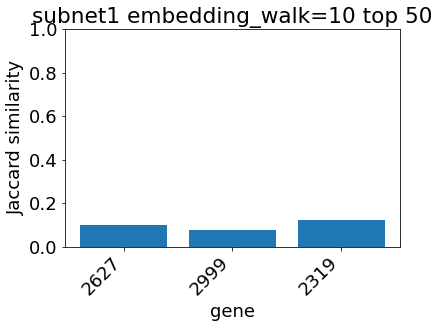

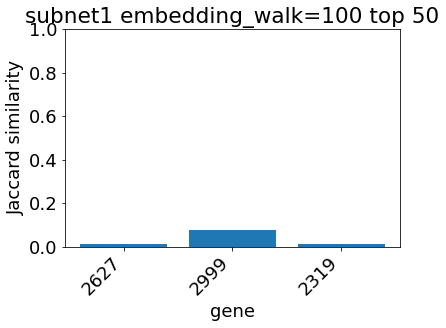

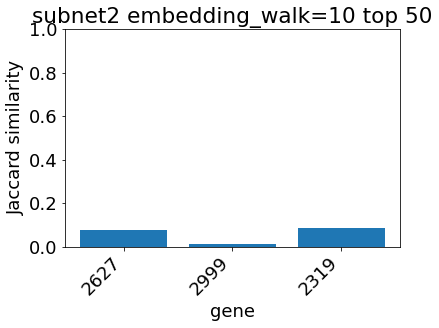

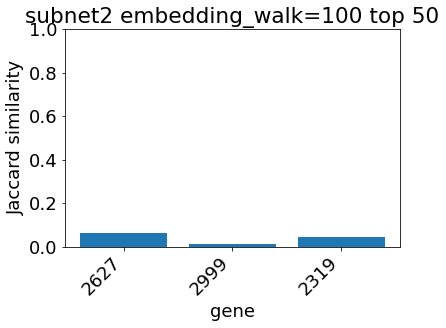

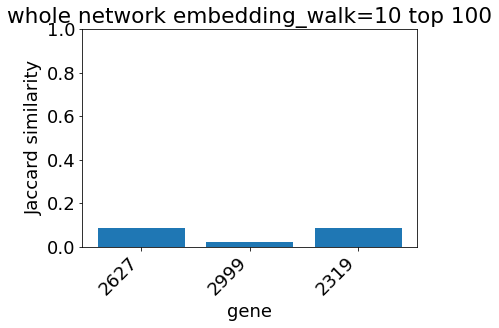

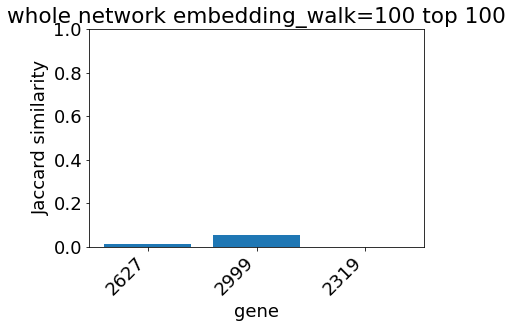

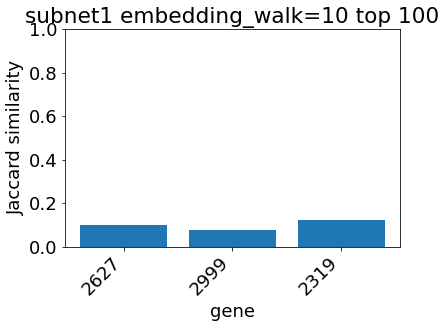

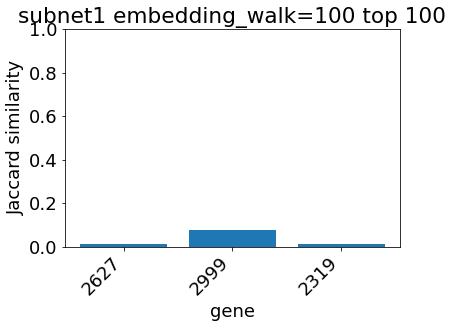

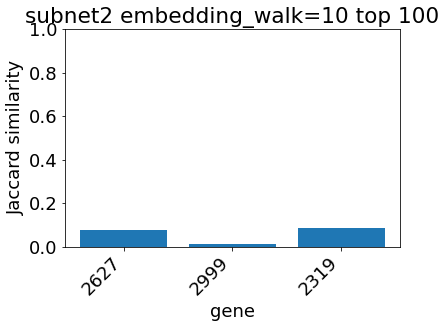

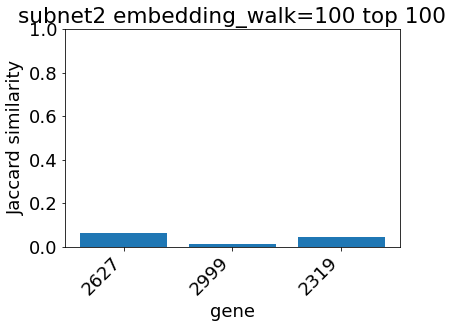

In [17]:
emb_list1 = [subnet1_emb, subnet1_sub1_emb, subnet1_sub2_emb]
emb_list2 = [subnet1_emb_100, subnet1_sub1_emb_100, subnet1_sub2_emb_100]
emb_names = ['whole network embedding', 'subnet1 embedding', 'subnet2 embedding']
n_list = [10, 50, 100]
for n in n_list:
    for i in range(3):
        get_closest_genes_jaccard(subnet1_edge, emb_list1[i], 50, f'{emb_names[i]}_walk=10 top {n}')
        get_closest_genes_jaccard(subnet1_edge, emb_list2[i], 50, f'{emb_names[i]}_walk=100 top {n}')

# Take top 100 DEGs and make a network: problem is 100 genes is still a pretty small network and subset of that is even smaller --> no overlap at all for jaccard

In [54]:
de_data = pd.read_csv('G:/Shared drives/NIAAA_ASSIST/Data/HDID_data/de_data.csv')
de_data['abs_log2FC'] = abs(de_data['log2FoldChange'])

In [73]:
expression = pd.read_csv('G:/Shared drives/NIAAA_ASSIST/Data/HDID_data/PFC_HDID_norm_exp.txt', sep = '\t')
top100_DEGs = de_data.sort_values('abs_log2FC', ascending=False)['id'].reset_index(drop = True)[:100]
top100_expression = expression[expression.id.isin(top100_DEGs)].reset_index(drop = True)
top100_expression.to_csv('G:/Shared drives/NIAAA_ASSIST/Data/HDID_data/eda_derived/top100_expression.txt', index = 0, sep = '\t') # export for wgcna

In [58]:
top100_tom = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\HDID_data\eda_derived\top100_tom.csv', index_col = 0)
top100_wgcna = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\HDID_data\eda_derived\top100_wgcna_modules.csv')

In [60]:
comm_df1 = run_louvain(top100_tom, 1, -1) # default setting
comm_df2 = run_louvain(top100_tom, 1, 1)

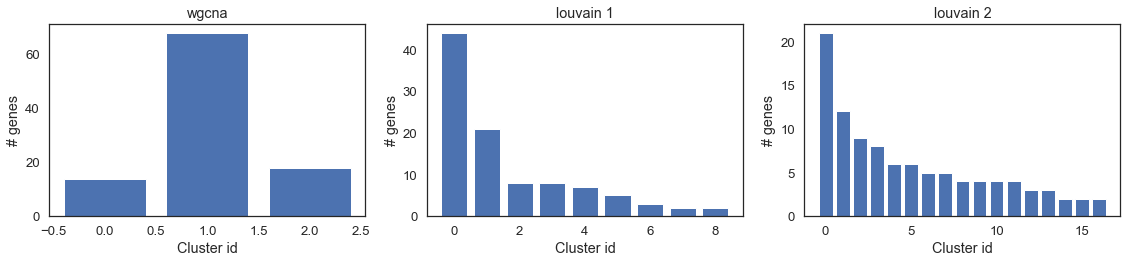

In [166]:
comm_dfs = [top100_wgcna,comm_df1, comm_df2]
comm_names = ['wgcna','louvain 1', 'louvain 2']
plot_gene_cnt_each_cluster(comm_dfs, 'louvain_label', comm_names)

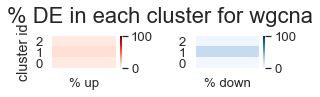

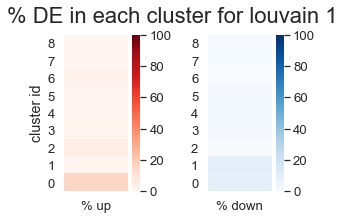

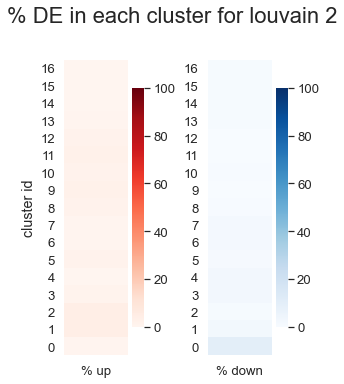

In [167]:
for i, cluster_df in enumerate(comm_dfs):
    cluster_DE_perc(cluster_df, 'louvain_label', comm_names[i], deseq = de_data)

Figure deg_mod=[1],non_deg_mod=[0],num_genes=14,min_weight=5e-06 has been saved.


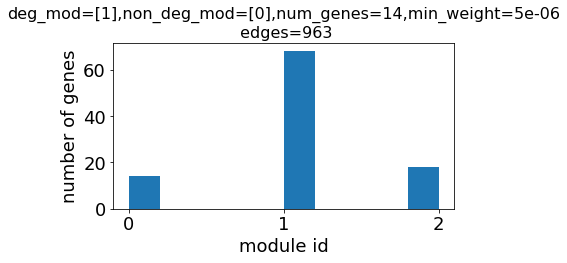

Figure deg_mod=[1],non_deg_mod=[2],num_genes=18,min_weight=5e-05 has been saved.


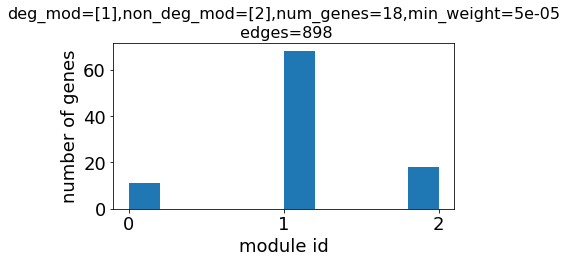

Figure deg_mod=[1],non_deg_mod=[],num_genes=50,min_weight=0.0005 has been saved.


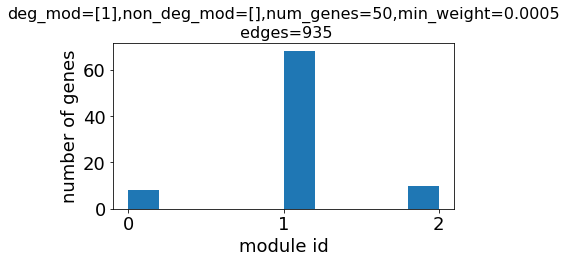

In [55]:
subnetwork_path = r'G:\Shared drives\NIAAA_ASSIST\Data\HDID_data\eda_derived\subnetworks_Feb11'
G1_n_0, module1_n_0_df, subnetwork_name1 = get_subnetwork([1], 14, 0.000005, top100_tom, comm_df = top100_wgcna, deseq = de_data, non_deg_modules = [0], plot_hist = True, 
                                         hist_dir = subnetwork_path, subnetwork_dir = subnetwork_path)
G1_n_2, module1_n_2_df, subnetwork_name2 = get_subnetwork([1], 18, 0.00005, top100_tom, comm_df = top100_wgcna, deseq = de_data, non_deg_modules = [2], plot_hist = True, 
                                         hist_dir = subnetwork_path, subnetwork_dir = subnetwork_path)
G1, module1_df, subnetwork_name3 = get_subnetwork([1], 50, 0.0005, top100_tom, comm_df = top100_wgcna, deseq = de_data, non_deg_modules = [], plot_hist = True, 
                                         hist_dir = subnetwork_path, subnetwork_dir = subnetwork_path)

In [135]:
%%time
embedding_path = prefix +'/Shared drives/NIAAA_ASSIST/Data/HDID_data/embedding_derived/embedding_Feb12/'
top100_G = nx.convert_matrix.from_pandas_adjacency(top100_tom)
network_to_embed = [top100_G, G1_n_0, G1_n_2, G1]
network_to_embed_names = ['whole network', subnetwork_name1, subnetwork_name2, subnetwork_name3]
emb_list = []
kmeans_list = []
for i, G in enumerate(network_to_embed):
    emb_df = network_embedding(G, 16, 10, 10, embedding_path, network_to_embed_names[i])
    emb_list.append(emb_df)
    kmeans_list.append(run_kmeans(emb_df, 3))

Computing transition probabilities:  46%|████████████████████▋                        | 46/100 [00:00<00:00, 455.44it/s]

embedding data saved


Computing transition probabilities:  43%|███████████████████▉                          | 42/97 [00:00<00:00, 410.16it/s]

embedding data saved


Generating walks (CPU: 1):   0%|                                                                 | 0/10 [00:00<?, ?it/s]

embedding data saved


Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.38it/s]


embedding data saved
Wall time: 7.42 s


In [57]:
# convert df from adjacency to edgelist
def adj_to_edgelist(adj_df):
    adj_df_copy = adj_df.copy()
    adj_df_copy.values[tuple([np.arange(len(adj_df_copy))]*2)] = np.nan
    edge_df = adj_df_copy.stack().reset_index()
    edge_df['level_0'] = list(map(lambda x:int(x.split('_')[1]), edge_df['level_0']))
    edge_df['level_1'] = list(map(lambda x:int(x.split('_')[1]), edge_df['level_1']))
    return edge_df

In [218]:
# output edgelist for ohmnet
subnet_names = [subnetwork_name1, subnetwork_name2, subnetwork_name3]
for i, subnet in enumerate([module1_n_0_df, module1_n_2_df, module1_df]):
    edge_df = adj_to_edgelist(subnet)
    edge_df.to_csv(f'C:/Users/bbche/Documents/GitRepos/ohmnet/data/edgelists/mouse_100_{subnet_names[i]}.txt', sep = '\t', index = 0, header = None)

In [58]:
# join the subnetworks into 1 df and convert the df to the format that MNE can handle 
edge_df_list = []
subnet_names = [subnetwork_name1, subnetwork_name2, subnetwork_name3]
for i, subnet in enumerate([module1_n_0_df, module1_n_2_df, module1_df]):
    edge_df = adj_to_edgelist(subnet)
    edge_df['edge_type'] = i+1
    edge_df_list.append(edge_df)
edge_df_joined = pd.concat(edge_df_list)
edge_df_joined = edge_df_joined[['edge_type', 'level_0', 'level_1', 0]]

In [59]:
id_dict = {}
i = 1
for id in edge_df_joined.level_0.unique():
    id_dict[id] = i
    i += 1
edge_df_joined.level_0 = edge_df_joined.level_0.map(id_dict)
edge_df_joined.level_1 = edge_df_joined.level_1.map(id_dict)
edge_df_joined.to_csv(r'C:\Users\bbche\Documents\GitRepos\MNE\data\mouse_small_multiplex.txt', sep = ' ', index = 0, header = None)

In [52]:
# import original network and embedding data
top100_tom = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\HDID_data\eda_derived\top100_tom.csv', index_col = 0)
top100_wgcna = pd.read_csv(r'G:\Shared drives\NIAAA_ASSIST\Data\HDID_data\eda_derived\top100_wgcna_modules.csv')

embedding_path = prefix +'/Shared drives/NIAAA_ASSIST/Data/HDID_data/embedding_derived/embedding_Feb12'
network_to_embed = []
network_to_embed_names = []
kmeans_list = []
for file in os.listdir(embedding_path):
    emb_df = pd.read_csv(os.path.join(embedding_path, file), index_col = 0)
    network_to_embed.append(emb_df)
    network_to_embed_names.append(file[22:-4])
    kmeans_list.append(run_kmeans(emb_df, 3))

In [60]:
def read_ohmnet_emb(emb_path):
    ohmnet_emb = pd.read_csv(emb_path, sep = ' ', skiprows=1, header = None, index_col = 0)
    ohmnet_index = list(ohmnet_emb.index)
    new_index1 = list(map(lambda x:int(x.split('__')[1]), ohmnet_index))
    new_index2 = list(map(lambda x: 'ILMN_' + str(x), new_index1)) # add ILMN_ back to the gene id
    ohmnet_emb.index = new_index2
    return ohmnet_emb

In [61]:
def get_key(val, id_dict):
    for k, v in id_dict.items():
         if val == v:
                return k

In [66]:
import json
def read_mne_emb(emb_path, id_dict):
    mne_emb = np.load(emb_path)
    with open(r'C:\Users\bbche\Documents\GitRepos\MNE\Model\index2word.json') as json_file:
        data = json.load(json_file)
    mne_emb_df = pd.DataFrame(mne_emb, index = data)
    mne_emb_df.index = list(map(lambda x:int(x), mne_emb_df.index))
    mne_emb_df.index = list(map(lambda x:'ILMN_' + str(get_key(x, id_dict)), mne_emb_df.index)) # map it back to the dictionary and ILMN_ back to the gene id
    return mne_emb_df

In [63]:
ohmnet_emb = read_ohmnet_emb(r'C:\Users\bbche\Documents\GitRepos\ohmnet\top100\internal_vectors.emb')
mne_emb = read_mne_emb(r'C:\Users\bbche\Documents\GitRepos\MNE\Model\embeddings.npy', id_dict)

## Determine jaccard of closest genes

In [71]:
def get_closest_genes_jaccard_v2(network, emb, gene_list, top_n, title):
    ed_data = ed(emb, emb)
    ed_df = pd.DataFrame(ed_data, index = emb.index, columns = emb.index)
    closest_genes1 = [] # find closest genes in the subnetwork
    closest_genes2 = [] # find closest genes in the embedding
    for gene in gene_list:
        closest_genes1.append(network[gene].sort_values(ascending = False)[:top_n].index)
        top_n_genes = ed_df[gene].sort_values()[1:top_n+1].index
        closest_genes2.append(top_n_genes)
    jac_list = []
    for i in range(len(closest_genes1)):
        jac_list.append(jaccard_similarity(closest_genes1[i], closest_genes2[i]))
#     xticks = le.inverse_transform(subnet1_edge.source.unique())
    plt.rcParams.update({'font.size':18})
    plt.bar(gene_list, jac_list)
    plt.ylim(0, 1)
    plt.ylabel('Jaccard similarity')
    plt.xlabel('gene')
    plt.xticks(rotation = 45, ha = 'right')
    plt.title(title)
    plt.show()
    plt.close()

In [69]:
network_to_embed += [ohmnet_emb, mne_emb]
network_to_embed_names += ['Ohmnet embedding', 'MNE embedding']
for emb in [ohmnet_emb, mne_emb]:
    kmeans_list.append(run_kmeans(emb, 3))

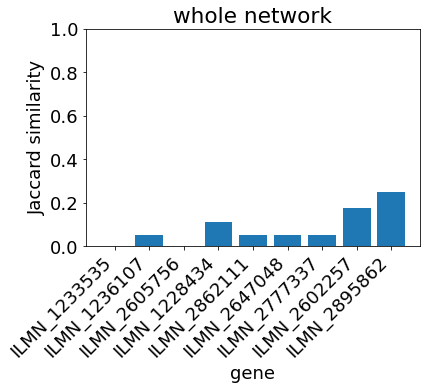

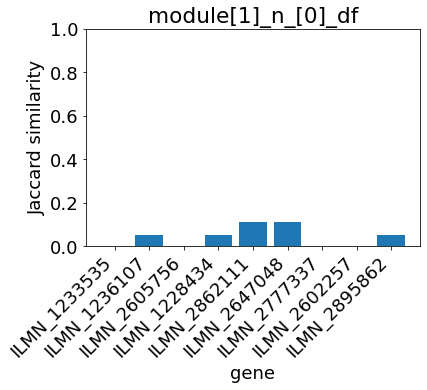

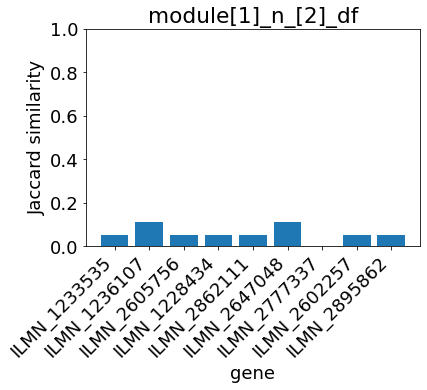

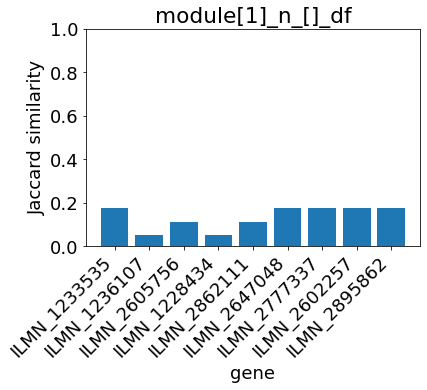

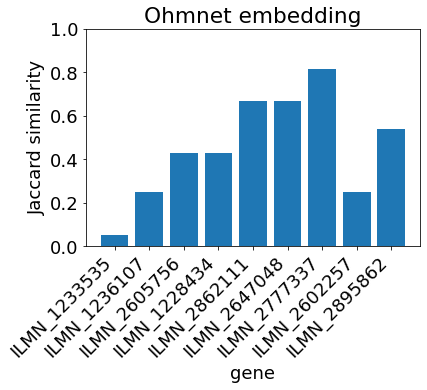

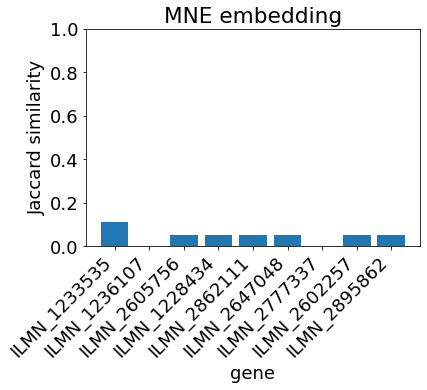

In [74]:
for i, emb in enumerate(network_to_embed):
    get_closest_genes_jaccard_v2(top100_tom, emb, top100_DEGs[1:10], 10, network_to_embed_names[i])

## compare by jaccard on clustering

Removing existing folder: output
Created folder output


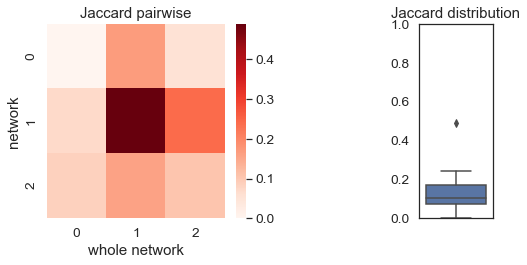

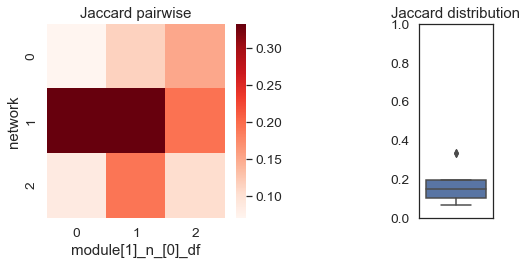

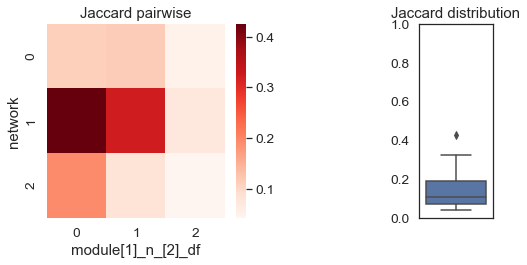

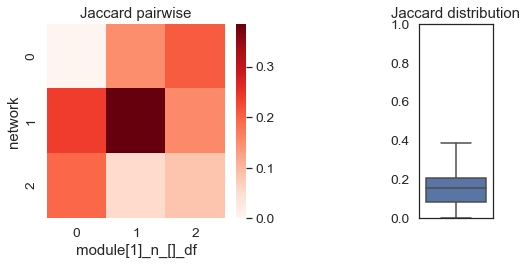

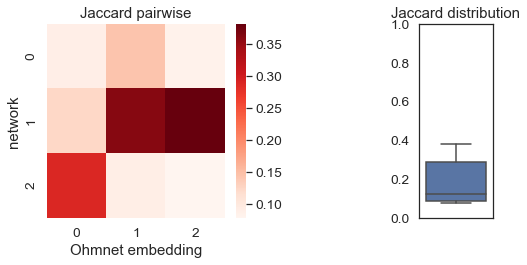

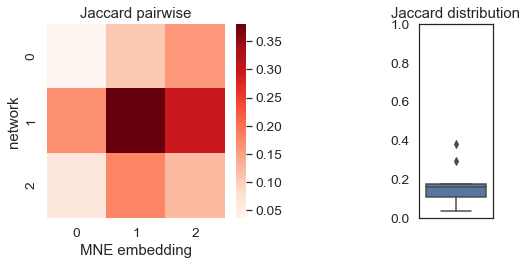

In [75]:
for i, kmean in enumerate(kmeans_list):
    cluster_jaccard_v2(top100_wgcna, kmean, 'louvain_label', 'kmean_label', ['network', network_to_embed_names[i]])

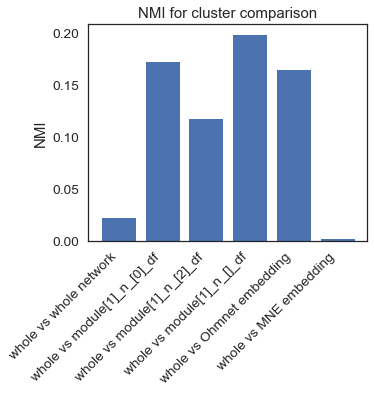

In [80]:
network_comparison_names = ['whole' + f' vs {network_to_embed_names[i]}' for i in range(len(network_to_embed_names))]
plot_cluster_nmi_comparison_v3('network', cluster1 = top100_wgcna, cluster1_column = 'louvain_label', 
                               cluster2_list= kmeans_list, cluster2_column = 'kmean_label', comparison_names = network_comparison_names)

# Get 3 subnetworks from the mouse PFC tom data with ~ 10k edges in each for ohmnet

In [108]:
mouse_tom = pd.read_csv("G:/Shared drives/NIAAA_ASSIST/Data/pipeline/mouse/network_analysis/tom.csv", index_col = 0)
de_data = pd.read_csv("G:/Shared drives/NIAAA_ASSIST/Data/HDID_data/de_data.csv")
wgcna_modules = pd.read_csv("G:/Shared drives/NIAAA_ASSIST/Data/pipeline/mouse/network_analysis/wgcna_modules.csv")

Figure deg_mod=[0, 1],non_deg_mod=[2],num_genes=60,min_weight=0.13 has been saved.


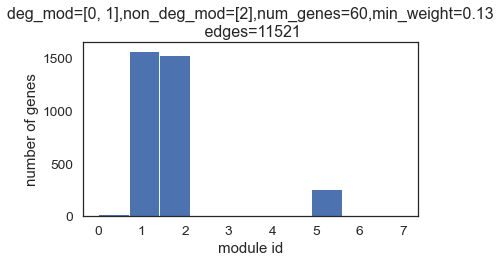

Figure deg_mod=[0, 1],non_deg_mod=[3],num_genes=100,min_weight=0.066 has been saved.


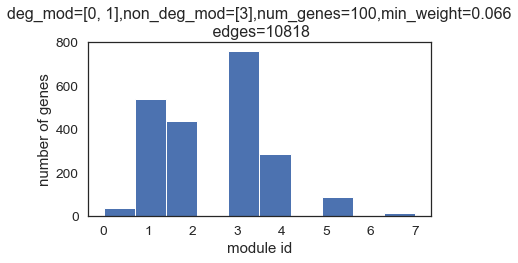

Figure deg_mod=[0, 1],non_deg_mod=[4],num_genes=80,min_weight=0.073 has been saved.


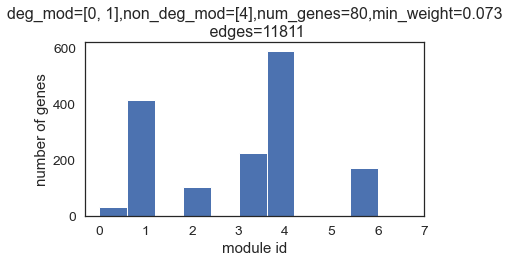

In [110]:
subnetwork_path = r'G:\Shared drives\NIAAA_ASSIST\Data\HDID_data\eda_derived\subnetworks_Feb14'
G01_n_2, module01_n_2_df, subnetwork_name1 = get_subnetwork([0,1], 60, 0.13, mouse_tom, comm_df = wgcna_modules, deseq = de_data, non_deg_modules = [2], plot_hist = True, 
                                         hist_dir = subnetwork_path, subnetwork_dir = subnetwork_path)
G01_n_3, module01_n_3_df, subnetwork_name2 = get_subnetwork([0,1], 100, 0.066, mouse_tom, comm_df = wgcna_modules, deseq = de_data, non_deg_modules = [3], plot_hist = True, 
                                         hist_dir = subnetwork_path, subnetwork_dir = subnetwork_path)
G01_n_4, module01_n_4_df, subnetwork_name3 = get_subnetwork([0,1], 80, 0.073, mouse_tom, comm_df = wgcna_modules, deseq = de_data, non_deg_modules = [4], plot_hist = True, 
                                         hist_dir = subnetwork_path, subnetwork_dir = subnetwork_path)

In [111]:
# output edgelist for ohmnet (this set is to test how long it will take for ohmnet for embed 3 subnetworks with 10k edges)
subnet_names = [subnetwork_name1, subnetwork_name2, subnetwork_name3]
for i, subnet in enumerate([module01_n_2_df, module01_n_3_df, module01_n_4_df]):
    edge_df = adj_to_edgelist(subnet)
    edge_df.to_csv(f'C:/Users/bbche/Documents/GitRepos/ohmnet/data/edgelists/mouse_{subnet_names[i]}.txt', sep = '\t', index = 0, header = None)